## Домашнее задание №2: Глубинные нейронные сети. Pytorch

### Пожалуйста, заполните имя

In [1]:
STUDENT_NAME = "FirstName LastName" # For example, Fedor Petriaikin

In [2]:
# Включает режим проверки
try:
    import train_utils
    TEST_MODE = True
except:
    TEST_MODE = False

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh
import torch.nn as nn
from torch import Tensor
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать обучить нейронную сеть с помощью фреймворка Pytorch, изучить подходы к инициализации нейронных сетей и реализовать слои, улучшающие сходимость глубинных нейронных сетей.

### Часть 1. Введение в Pytorch

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица.  
Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.  

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


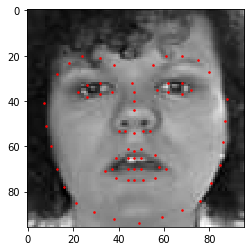

In [5]:
# Пример работы с датасетом

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [6]:
# Далее нам нужно сформировать свой датасет
# См. https://pytorch.org/docs/stable/torchvision/datasets.html

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    # Из этой функции нужно вернуть dict вида {'image': image, 'landmarks': landmarks}
    # Где image и landmarks - получаются так же, как в функции выше
    # Не забудьте применить transform - это нужно для превращения в тензор
    def __getitem__(self, idx):
        ### YOUR CODE HERE
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
# Превращение в torch.Tensor лучше делать как отдельное преобразование -
# это позволит работать с датасетом не только в рамках pytorch
# Выходом преобразования должны быть (X, y) - 2 одномерных тензора torch.FloatTensor
# Для этого воспользуйтеь методом ndarray.ravel()
# Получающиеся размерности X = torch.Size([9216]), y = torch.Size([136])

# Обратите внимание на типы тензоров в pytorch! Это очень важный их параметр!
# См. https://pytorch.org/docs/stable/tensors.html#torch.Tensor.type

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    # Превращает во FloatTensor входные данные и "вытягивает" размерности в одну строку
    # (т.к. у нас не сверточные сети - нет смысла хранить размерности)
    def __call__(self, sample):
        ### YOUR CODE HERE
        image, landmarks = sample['image'], sample['landmarks']
        X = torch.from_numpy(image.ravel()).type(torch.FloatTensor)
        y = torch.from_numpy(landmarks.ravel()).type(torch.FloatTensor)
        return X, y

In [12]:
# Если не отделять папку dataset от этого notebook, то этот код
# 1) должен создать train и test
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor() # Чтобы получить тензоры
                                     )
test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

# 2) сформировать dataloader-ы 
# См. https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True)

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid). Loss - MSE, оптимизатор - Adam с learning rate 0.1 (остальные параметры оптимизатора по умолчанию). Обучайте сети в течении 4 эпох - нам не нужно здесь качество  
Для каждой архитектуры постройте графики для функции потерь на train/test


В этом задании **нет** порога качества - оно нужно, чтобы освоиться с pytorch

In [13]:
def simple_train(network, train_dataloader, test_dataloader, epochs):
    optimizer = torch.optim.Adam(network.parameters(), lr=0.1)
    loss = MSELoss()
    # YOUR CODE HERE
    pass

In [14]:
# Массив из nn.Sequential - сетей для обучения
networks = [ Sequential(Linear(1 * 96 * 96, 200), Tanh(),
                     Linear(200, 2 * 68)) ] ### YOUR CODE HERE

In [15]:
# Должен построить графики и написать значение MSE на train и test для каждой из архитектур
for n in networks:
    simple_train(n, train_dataloader, test_dataloader, 4)

Epoch 3... (Train/Test) Loss: 18.138/19.311	


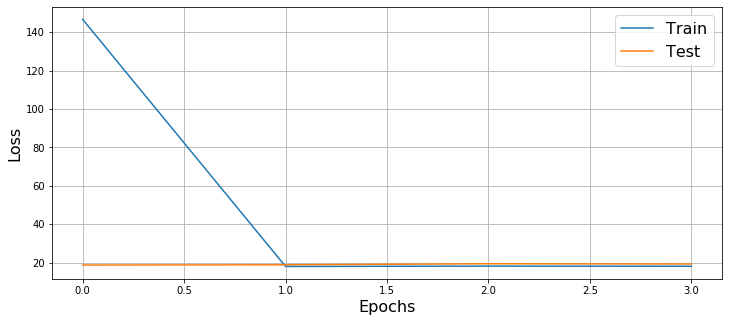

In [16]:
# Проверка
from importlib import reload
reload(train_utils)

if TEST_MODE:
    for n in networks:
        train_utils.train(n, train_dataloader, test_dataloader, 4, MSELoss())

In [17]:
# Посмотрим на предикт

def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batch
    batch_size = len(images_batch)

    images_batch = images_batch.view(-1, 96, 96)
    landmarks_batch = landmarks_batch.view(-1, 68, 2)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

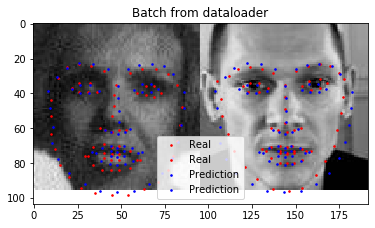

In [18]:
final_nw_pos = None # Выберите номер лучшей архитектуры в списке networks

test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
batch = next(iter(test_dataloader))
x = batch[0]
y_pred = networks[0](x)
y = batch[1]
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

### Часть 2. Инициализация нейронных сетей
В этом задании мы вернемся к нашему знакомому датасету MNIST. Напомним:

In [2]:
from torchvision.datasets import MNIST

to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
# Тестовые батчи. Нарисуем их, а потом будем пропускать их через нейронную сеть
images_train, labels_train = next(iter(train_loader))

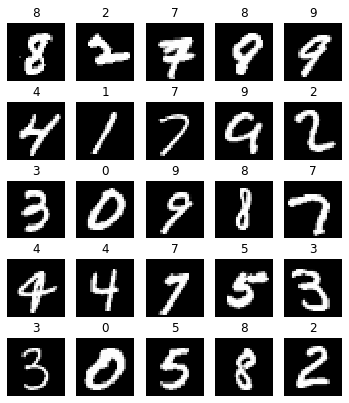

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train.numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(labels_train.numpy()[i])
    plt.axis('off')

In [65]:
# Нам понадобятся некоторые вспомогательные функции для распечатки градиентов

ITER = 0
def forward_hook(self, input_, output):
    global ITER
    std = input_[0].std().item()
    print(ITER, ': forward', std)
    ITER += 1

def backward_hook(self, grad_input, grad_output):
    global ITER
    std = grad_input[0].std().item()
    print(ITER, ': backward', std)
    ITER -= 1

# Пользоваться ими можно так (пример функтора создания слоя)
def create_sample_linear(inp_size, out_size):
    layer = nn.Linear(inp_size, out_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=0.1)
    return layer

In [74]:
# Функция пропуска тестового батча через нейронную сеть
def sample_propagation(network):
    global ITER
    ITER = 0

    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1)
    y = labels_train[:n_objects]
    print(X.shape, y.shape)

    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [75]:
# Функция создания тестовой нейронной сети. Следует создавать 200 промежуточных слоев (и activation между ними)
# Принимает функторы создания слоев с "говорливыми" hook-ами (см. пример функтора создания слоя выше),
# возвращает nn.Sequential из них
# Не забывайте про *list для распаковки списков в параметры

# layers_creator - принимает массив, добавляет в него новый линейный промежуточный слой 500x500
# start_layer_creator - принимает массив, добавляет в него первый слой (784 --> 500)
# end_layer_creator - принимает массив, добавляет в него последний слой (500 --> 10)

def create_network(layers_creator,
                   start_layer_creator=lambda layers: layers.append(create_sample_linear(784, 500)),
                   end_layer_creator=lambda layers: layers.append(create_sample_linear(500, 10)),
                   activation=nn.Tanh):
    ### YOUR CODE HERE
    pass

    layers = []
    start_layer_creator(layers)
    layers.append(activation())
    
    for i in range(200):
        layers_creator(layers)
        layers.append(activation())
    
    end_layer_creator(layers) 
    layers.append(nn.LogSoftmax())
    
    network = nn.Sequential(*layers)
    return network

Сделайте функторы создания слоев (линейных, 500x500):  
1. Инициализированных N(0, 0.1) - см. create_sample_linear
2. Инициализированных по He
3. Инициализированных по Xavier

Обучите нейронные сети с каждым из методов инициализации. Архитектура - 784 -> 500 x (200 раз) -> 10. В качестве активации возьмите tanh (1-2), ReLU (Xavier). Посмотрите как изменяются градиенты на forward и backward (с помощью sample_propagation). Сделайте выводы

In [76]:
### YOUR CODE HERE

def simple_creator(layers):
    layers.append(create_sample_linear(500, 500))

network = create_network(simple_creator)

In [77]:
sample_propagation(network)

torch.Size([100, 784]) torch.Size([100])
0 : forward 1.011888027191162
1 : forward 0.8495547771453857
2 : forward 0.790351390838623
3 : forward 0.7704376578330994
4 : forward 0.7649886012077332
5 : forward 0.765237033367157
6 : forward 0.7681969404220581
7 : forward 0.7664382457733154
8 : forward 0.766731321811676
9 : forward 0.7630622982978821
10 : forward 0.7661294937133789
11 : forward 0.7659890055656433
12 : forward 0.7648018598556519
13 : forward 0.7663562893867493
14 : forward 0.7643502354621887
15 : forward 0.7653845548629761
16 : forward 0.7654205560684204
17 : forward 0.7661718130111694
18 : forward 0.7645595669746399
19 : forward 0.7649946212768555
20 : forward 0.7632773518562317
21 : forward 0.7676026821136475
22 : forward 0.7673364281654358
23 : forward 0.7665778398513794
24 : forward 0.7671713829040527
25 : forward 0.7675957679748535
26 : forward 0.7633972764015198
27 : forward 0.7621702551841736
28 : forward 0.7631352543830872
29 : forward 0.7648142576217651
30 : forward 

133 : backward 2980.56689453125
132 : backward 3444.3056640625
131 : backward 4340.5654296875
130 : backward 5405.53125
129 : backward 6565.19580078125
128 : backward 8155.400390625
127 : backward 10666.1005859375
126 : backward 12591.9423828125
125 : backward 15115.7890625
124 : backward 18914.439453125
123 : backward 22573.8359375
122 : backward 26686.537109375
121 : backward 31528.333984375
120 : backward 40929.125
119 : backward 49328.67578125
118 : backward 63972.6796875
117 : backward 74433.109375
116 : backward 92661.4921875
115 : backward 111049.15625
114 : backward 134550.4375
113 : backward 154275.140625
112 : backward 178277.53125
111 : backward 227142.59375
110 : backward 275793.625
109 : backward 337680.75
108 : backward 417545.34375
107 : backward 533989.5
106 : backward 648099.8125
105 : backward 787651.625
104 : backward 931984.75
103 : backward 1096264.875
102 : backward 1328190.625
101 : backward 1700683.125
100 : backward 1932626.625
99 : backward 2282819.5
98 : back

*Выводы:*

Спасибо за выполнение заданий!